In [1]:
# Commonly used CV tools
import os
import cv2     # for capturing videos
import math   # for mathematical operations
import pickle
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
import pandas as pd
import numpy as np    # for mathematical operations
from skimage.transform import resize   # for resizing images
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score
from glob import glob
from tqdm import tqdm

# for model architectures
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import torch.utils.data as data
import torchvision
from torch.autograd import Variable
from functions import *


### Read file names into the train dataframe

In [2]:
# open the .txt file which have names of training videos
f = open("trainlist01.txt", "r")
temp = f.read()
videos = temp.split('\n')

# creating a dataframe having video names
train = pd.DataFrame()
train['video_name'] = videos
train = train[:-1]
train.head()

,video_name
0,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c01.avi 1
1,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c02.avi 1
2,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c03.avi 1
3,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c04.avi 1
4,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c05.avi 1


### Get the tagnames from folder names

In [3]:
train_video_tag = []
for i in range(train.shape[0]):
    train_video_tag.append(train['video_name'][i].split('/')[0])

train['tag'] = train_video_tag
train.head()

,video_name,tag
0,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c01.avi 1,ApplyEyeMakeup
1,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c02.avi 1,ApplyEyeMakeup
2,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c03.avi 1,ApplyEyeMakeup
3,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c04.avi 1,ApplyEyeMakeup
4,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c05.avi 1,ApplyEyeMakeup


### Create test data frame and corresponding tags

In [4]:
# open the .txt file which have names of test videos
f = open("testlist01.txt", "r")
temp = f.read()
videos = temp.split('\n')

# creating a dataframe having video names
test = pd.DataFrame()
test['video_name'] = videos
test = test[:-1]

# creating tags for test videos
test_video_tag = []
for i in range(test.shape[0]):
    test_video_tag.append(test['video_name'][i].split('/')[0])
    
test['tag'] = test_video_tag
test.head()

,video_name,tag
0,ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c01.avi,ApplyEyeMakeup
1,ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c02.avi,ApplyEyeMakeup
2,ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c03.avi,ApplyEyeMakeup
3,ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c04.avi,ApplyEyeMakeup
4,ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c05.avi,ApplyEyeMakeup


## Create a new folder 'train_1' to contain extracted frames
use `cap.get( )` from `cv2` to get certain properties of the video capture

In [5]:
# storing the frames from training videos
for i in tqdm(range(train.shape[0])):
    count = 0
    videoFile = train['video_name'][i]
    cap = cv2.VideoCapture('UCF-101/'+videoFile.split(' ')[0])
    frameRate = cap.get(5) # get frames per second
    print(f'The video is taking at {frameRate} frames per second')
    
    while(cap.isOpened()):
        frameId = cap.get(1) # get current frame number
        ret, frame = cap.read()
        if(ret != True):
            break
        if (frameId % math.floor(frameRate) == 0):
            # storing the frames in a new folder named train_1
            filename = 'train_1/' + videoFile.split('/')[1].split(' ')[0] +"_frame%d.jpg" % count;count+=1
            cv2.imwrite(filename, frame)
    cap.release()

  0%|          | 1/9537 [00:00<1:13:43,  2.16it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  0%|          | 7/9537 [00:00<39:22,  4.03it/s]  

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  0%|          | 13/9537 [00:00<22:20,  7.11it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  0%|          | 18/9537 [00:01<16:42,  9.50it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  0%|          | 26/9537 [00:01<10:43, 14.77it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  0%|          | 34/9537 [00:01<07:28, 21.20it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  0%|          | 42/9537 [00:01<06:23, 24.74it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  1%|          | 50/9537 [00:02<05:43, 27.65it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  1%|          | 58/9537 [00:02<05:11, 30.40it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  1%|          | 62/9537 [00:02<05:19, 29.66it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  1%|          | 70/9537 [00:02<05:09, 30.56it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  1%|          | 74/9537 [00:02<05:14, 30.08it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  1%|          | 81/9537 [00:03<05:36, 28.06it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  1%|          | 88/9537 [00:03<05:28, 28.78it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  1%|          | 92/9537 [00:03<05:07, 30.75it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  1%|          | 101/9537 [00:03<04:55, 31.90it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  1%|          | 105/9537 [00:03<05:55, 26.54it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  1%|          | 112/9537 [00:04<05:22, 29.21it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  1%|▏         | 120/9537 [00:04<05:05, 30.87it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  1%|▏         | 124/9537 [00:04<05:15, 29.87it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  1%|▏         | 132/9537 [00:04<05:14, 29.91it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  1%|▏         | 140/9537 [00:05<04:51, 32.23it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  2%|▏         | 148/9537 [00:05<04:38, 33.75it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  2%|▏         | 156/9537 [00:05<04:41, 33.33it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  2%|▏         | 165/9537 [00:05<04:21, 35.89it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  2%|▏         | 169/9537 [00:05<04:32, 34.33it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  2%|▏         | 178/9537 [00:06<04:24, 35.43it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  2%|▏         | 182/9537 [00:06<04:44, 32.89it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  2%|▏         | 190/9537 [00:06<05:32, 28.12it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  2%|▏         | 199/9537 [00:06<04:56, 31.46it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  2%|▏         | 203/9537 [00:06<05:01, 30.97it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  2%|▏         | 207/9537 [00:07<05:58, 26.05it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  2%|▏         | 213/9537 [00:07<07:11, 21.60it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  2%|▏         | 220/9537 [00:07<06:04, 25.59it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  2%|▏         | 226/9537 [00:07<05:45, 26.94it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  2%|▏         | 232/9537 [00:08<05:43, 27.12it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  2%|▏         | 235/9537 [00:08<06:00, 25.82it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  3%|▎         | 242/9537 [00:08<06:07, 25.30it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  3%|▎         | 249/9537 [00:08<05:37, 27.49it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  3%|▎         | 258/9537 [00:08<04:34, 33.75it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  3%|▎         | 262/9537 [00:09<05:19, 29.00it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  3%|▎         | 274/9537 [00:09<04:07, 37.46it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  3%|▎         | 279/9537 [00:09<04:10, 36.91it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  3%|▎         | 284/9537 [00:09<04:35, 33.64it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  3%|▎         | 292/9537 [00:09<04:56, 31.16it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  3%|▎         | 301/9537 [00:10<04:44, 32.52it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  3%|▎         | 309/9537 [00:10<04:26, 34.66it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  3%|▎         | 313/9537 [00:10<04:55, 31.23it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  3%|▎         | 320/9537 [00:10<05:27, 28.13it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  3%|▎         | 326/9537 [00:11<06:15, 24.51it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  3%|▎         | 329/9537 [00:11<06:31, 23.52it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  4%|▎         | 335/9537 [00:11<07:09, 21.42it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  4%|▎         | 342/9537 [00:11<06:30, 23.56it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  4%|▎         | 349/9537 [00:12<05:56, 25.76it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  4%|▎         | 352/9537 [00:12<06:35, 23.24it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  4%|▎         | 355/9537 [00:12<06:30, 23.49it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  4%|▍         | 361/9537 [00:12<06:21, 24.06it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  4%|▍         | 368/9537 [00:12<05:57, 25.68it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  4%|▍         | 376/9537 [00:13<05:16, 28.96it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  4%|▍         | 379/9537 [00:13<05:49, 26.22it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  4%|▍         | 385/9537 [00:13<06:19, 24.12it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  4%|▍         | 393/9537 [00:13<05:20, 28.53it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  4%|▍         | 401/9537 [00:14<04:38, 32.82it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  4%|▍         | 410/9537 [00:14<04:15, 35.66it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  4%|▍         | 418/9537 [00:14<04:38, 32.79it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  4%|▍         | 422/9537 [00:14<04:56, 30.72it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  4%|▍         | 426/9537 [00:14<05:25, 27.99it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  5%|▍         | 434/9537 [00:15<05:06, 29.71it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  5%|▍         | 442/9537 [00:15<04:48, 31.57it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  5%|▍         | 451/9537 [00:15<04:11, 36.15it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  5%|▍         | 461/9537 [00:15<03:59, 37.96it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  5%|▍         | 465/9537 [00:15<04:02, 37.40it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  5%|▍         | 473/9537 [00:16<04:08, 36.47it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  5%|▌         | 481/9537 [00:16<04:15, 35.43it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  5%|▌         | 485/9537 [00:16<05:27, 27.60it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  5%|▌         | 489/9537 [00:16<06:17, 23.97it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  5%|▌         | 492/9537 [00:17<09:09, 16.47it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  5%|▌         | 495/9537 [00:17<10:23, 14.51it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  5%|▌         | 497/9537 [00:17<11:23, 13.23it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  5%|▌         | 502/9537 [00:17<10:24, 14.47it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  5%|▌         | 506/9537 [00:18<10:01, 15.01it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  5%|▌         | 508/9537 [00:18<10:42, 14.06it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  5%|▌         | 512/9537 [00:18<11:44, 12.80it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  5%|▌         | 517/9537 [00:18<08:55, 16.86it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  5%|▌         | 523/9537 [00:19<07:21, 20.41it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  6%|▌         | 526/9537 [00:19<08:45, 17.14it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  6%|▌         | 528/9537 [00:19<09:27, 15.88it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  6%|▌         | 533/9537 [00:19<09:01, 16.63it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  6%|▌         | 535/9537 [00:19<09:24, 15.94it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  6%|▌         | 539/9537 [00:20<10:36, 14.14it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  6%|▌         | 541/9537 [00:20<09:53, 15.17it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  6%|▌         | 546/9537 [00:20<10:41, 14.01it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  6%|▌         | 548/9537 [00:20<12:56, 11.58it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  6%|▌         | 552/9537 [00:21<12:14, 12.23it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  6%|▌         | 554/9537 [00:21<10:55, 13.69it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  6%|▌         | 558/9537 [00:21<12:24, 12.06it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  6%|▌         | 561/9537 [00:21<10:52, 13.75it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  6%|▌         | 566/9537 [00:22<09:42, 15.40it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  6%|▌         | 572/9537 [00:22<08:08, 18.36it/s]

The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second
The video is taking at 25.0 frames per second


  6%|▌         | 580/9537 [00:22<06:35, 22.66it/s]

The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second


  6%|▌         | 593/9537 [00:22<04:36, 32.35it/s]

The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second


  6%|▋         | 605/9537 [00:23<03:40, 40.55it/s]

The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second


  6%|▋         | 618/9537 [00:23<03:01, 49.22it/s]

The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second


  7%|▋         | 630/9537 [00:23<02:49, 52.64it/s]

The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second


  7%|▋         | 642/9537 [00:23<02:51, 51.80it/s]

The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second


  7%|▋         | 648/9537 [00:23<02:51, 51.73it/s]

The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second


  7%|▋         | 660/9537 [00:24<02:55, 50.47it/s]

The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second


  7%|▋         | 666/9537 [00:24<02:53, 51.16it/s]

The video is taking at 29.97002997002997 frames per second
The video is taking at 29.97002997002997 frames per second


KeyboardInterrupt: 

## Next, create a `.csv` file that contains paths to these images as well as their `class`

In [64]:
# get the names of all the images
images = glob('train_1/*.jpg')
train_image = []
train_class = []
for i in tqdm(range(len(images))):
    # create the image name
    train_image.append(images[i].split('/')[1])
    # create the class of this image, the activity name
    train_class.append(images[i].split('/')[1].split('_')[1])
    
# storing the images and their class in a dataframe
train_data = pd.DataFrame()
train_data['image'] = train_image
train_data['class'] = train_class

# save dataframe into `.csv` file
train_data.to_csv('UCF-101/train_new.csv', header = True, index=False)

100%|██████████| 73844/73844 [00:00<00:00, 600840.34it/s]


# Training most basic video classification model

## Here we will consider using the most basic architecure 3D-CNN with a very light base architecture: VGG-16
We have created our training image names are corresponding classes in a dataframe.
Now we just need to:
* Define model architecture
* Train and validate performance using unseen data
* Hyper-parameter tuning
* Upgrade model capability and repeat process for better accuracy

In [6]:
data_path = './jpegs_256'                 # preprocessed RGB images
action_name_path = './UCF101actions.pkl' # preprocessed action names
save_model_path = './Conv3D_ckpt'

#### 3D CNN patameters

In [7]:
# architecture parameters
fc_hidden1, fc_hidden2 = 256, 256
dropout = 0.0        # dropout probability

# training parameters
k = 101            # number of target category
epochs = 10        # do adjust here for shorter training period
batch_size = 8
learning_rate = 1e-4
log_interval = 10
img_x, img_y = 256, 342  # resize video 2d frame size

#### For 3D CNN we will need to determine a fixed No.frames and here we take 28 for UCF 101

In [8]:
begin_frame, end_frame, skip_frame = 1, 29, 1

In [9]:
def train(log_interval, model, device, train_loader, optimizer, epoch):
    model.train() # training model, enable dropout and 
    
    losses = []
    scores = []
    N_count = 0 # count total trained sample in one epoch
    
    for batch_idx, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device).view(-1,)
        
        N_count += X.size(0)
        
        optimizer.zero_grad()
        output = model(X)    # output size = (batch, number of classes)
        
        loss = F.cross_entropy(output, y)
        losses.append(loss.item())
        
        # to compute accuracy
        y_pred = torch.max(output, 1)[1]  # y_pred != output
        step_score = accuracy_score(y.cpu().data.squeeze().numpy(), y_pred.cpu().data.squeeze().numpy()) # computed on CPU
        scores.append(step_score)         
        
        loss.backward()
        optimizer.step()
        
        # show information
        if (batch_idx + 1) % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accu: {:.2f}%'.format(
                epoch + 1, N_count, len(train_loader.dataset), 100. * (batch_idx + 1) / len(train_loader), loss.item(), 100 * step_score))

    return losses, scores

In [10]:
def validation(model, device, optimizer, test_loader):
    # set model as testing mode
    model.eval()

    test_loss = 0
    all_y = []
    all_y_pred = []
    with torch.no_grad():
        for X, y in test_loader:
            # distribute data to device
            X, y = X.to(device), y.to(device).view(-1, )

            output = model(X)

            loss = F.cross_entropy(output, y, reduction='sum')
            test_loss += loss.item()                 # sum up batch loss
            y_pred = output.max(1, keepdim=True)[1]  # (y_pred != output) get the index of the max log-probability

            # collect all y and y_pred in all batches
            all_y.extend(y)
            all_y_pred.extend(y_pred)

    test_loss /= len(test_loader.dataset)

    # to compute accuracy
    all_y = torch.stack(all_y, dim=0)
    all_y_pred = torch.stack(all_y_pred, dim=0)
    test_score = accuracy_score(all_y.cpu().data.squeeze().numpy(), all_y_pred.cpu().data.squeeze().numpy())

    # show information
    print('\nTest set ({:d} samples): Average loss: {:.4f}, Accuracy: {:.2f}%\n'.format(len(all_y), test_loss, 100* test_score))

    # save Pytorch models of best record
    torch.save(model.state_dict(), os.path.join(save_model_path, '3dcnn_epoch{}.pth'.format(epoch + 1)))  # save spatial_encoder
    torch.save(optimizer.state_dict(), os.path.join(save_model_path, '3dcnn_optimizer_epoch{}.pth'.format(epoch + 1)))      # save optimizer
    print("Epoch {} model saved!".format(epoch + 1))

    return test_loss, test_score

## 3D CNN module

In [14]:
class CNN3D(nn.Module):
    def __init__(self, t_dim=120, img_x=90, img_y=120, drop_p=0.2, fc_hidden1=256, fc_hidden2=128, num_classes=50):
        super(CNN3D, self).__init__()

        # set video dimension
        self.t_dim = t_dim
        self.img_x = img_x
        self.img_y = img_y
        # fully connected layer hidden nodes
        self.fc_hidden1, self.fc_hidden2 = fc_hidden1, fc_hidden2
        self.drop_p = drop_p
        self.num_classes = num_classes
        self.ch1, self.ch2 = 32, 48
        self.k1, self.k2 = (5, 5, 5), (3, 3, 3)  # 3d kernel size
        self.s1, self.s2 = (2, 2, 2), (2, 2, 2)  # 3d strides
        self.pd1, self.pd2 = (0, 0, 0), (0, 0, 0)  # 3d padding

        # compute conv1 & conv2 output shape
        self.conv1_outshape = conv3D_output_size((self.t_dim, self.img_x, self.img_y), self.pd1, self.k1, self.s1)
        self.conv2_outshape = conv3D_output_size(self.conv1_outshape, self.pd2, self.k2, self.s2)

        self.conv1 = nn.Conv3d(in_channels=1, out_channels=self.ch1, kernel_size=self.k1, stride=self.s1,
                               padding=self.pd1)
        self.bn1 = nn.BatchNorm3d(self.ch1)
        self.conv2 = nn.Conv3d(in_channels=self.ch1, out_channels=self.ch2, kernel_size=self.k2, stride=self.s2,
                               padding=self.pd2)
        self.bn2 = nn.BatchNorm3d(self.ch2)
        self.relu = nn.ReLU(inplace=True)
        self.drop = nn.Dropout3d(self.drop_p)
        self.pool = nn.MaxPool3d(2)
        self.fc1 = nn.Linear(self.ch2 * self.conv2_outshape[0] * self.conv2_outshape[1] * self.conv2_outshape[2],
                             self.fc_hidden1)  # fully connected hidden layer
        self.fc2 = nn.Linear(self.fc_hidden1, self.fc_hidden2)
        self.fc3 = nn.Linear(self.fc_hidden2, self.num_classes)  # fully connected layer, output = multi-classes

    def forward(self, x_3d):
        # Conv 1
        x = self.conv1(x_3d)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.drop(x)
        # Conv 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.drop(x)
        # FC 1 and 2
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=self.drop_p, training=self.training)
        x = self.fc3(x)

        return x

In [15]:
from torchsummaryX import summary

In [21]:
input_X, label = next(iter(train_loader))
input_X.shape

torch.Size([8, 1, 28, 256, 342])

In [24]:
model = cnn3d.cpu()
summary(model, torch.zeros((8, 1, 28, 256, 342)))

              Kernel Shape           Output Shape       Params    Mult-Adds
Layer                                                                      
0_conv1   [1, 32, 5, 5, 5]  [8, 32, 12, 126, 169]       4.032k    1.022112G
1_bn1                 [32]  [8, 32, 12, 126, 169]         64.0         32.0
2_relu                   -  [8, 32, 12, 126, 169]            -            -
3_drop                   -  [8, 32, 12, 126, 169]            -            -
4_conv2  [32, 48, 3, 3, 3]     [8, 48, 5, 62, 84]       41.52k  1.07993088G
5_bn2                 [48]     [8, 48, 5, 62, 84]         96.0         48.0
6_relu                   -     [8, 48, 5, 62, 84]            -            -
7_drop                   -     [8, 48, 5, 62, 84]            -            -
8_fc1       [1249920, 256]               [8, 256]  319.979776M   319.97952M
9_fc2           [256, 256]               [8, 256]      65.792k      65.536k
10_fc3          [256, 101]               [8, 101]      25.957k      25.856k
------------

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_conv1,"[1, 32, 5, 5, 5]","[8, 32, 12, 126, 169]",4032.0,1.022112e+09
1_bn1,[32],"[8, 32, 12, 126, 169]",64.0,3.200000e+01
2_relu,-,"[8, 32, 12, 126, 169]",NaN,NaN
3_drop,-,"[8, 32, 12, 126, 169]",NaN,NaN
4_conv2,"[32, 48, 3, 3, 3]","[8, 48, 5, 62, 84]",41520.0,1.079931e+09
5_bn2,[48],"[8, 48, 5, 62, 84]",96.0,4.800000e+01
6_relu,-,"[8, 48, 5, 62, 84]",NaN,NaN
7_drop,-,"[8, 48, 5, 62, 84]",NaN,NaN
8_fc1,"[1249920, 256]","[8, 256]",319979776.0,3.199795e+08


In [28]:
from torchviz import make_dot, make_dot_from_trace

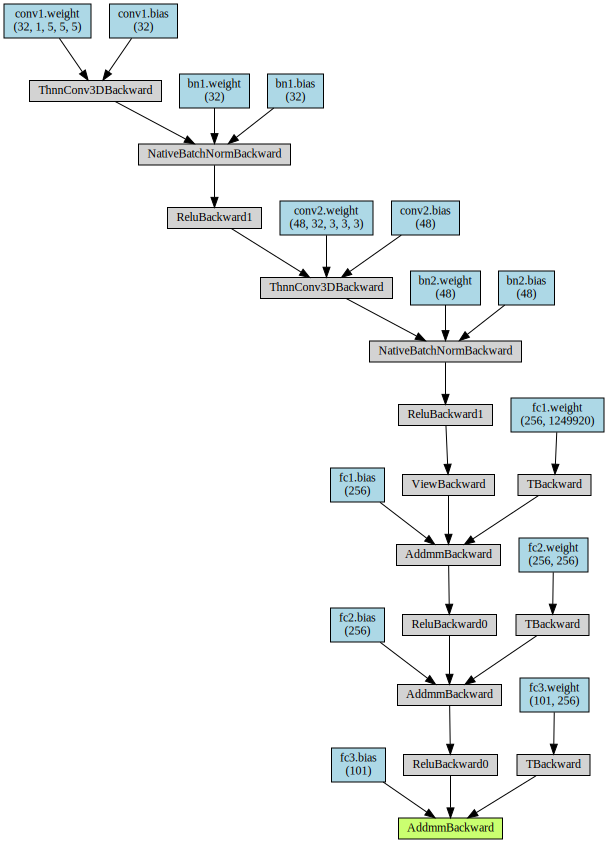

In [29]:
make_dot(model(torch.zeros((8, 1, 28, 256, 342))), params = dict(model.named_parameters()))

## Prepare for training

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 4, 'pin_memory': True} if torch.cuda.is_available() else {}

# load UCF101 label categories
with open(action_name_path, 'rb') as f:
    action_names = pickle.load(f)
    
print(f'we have {len(action_names)} categories')

# conver labels to categories using LabelEncoder()
le = LabelEncoder()
le.fit(action_names)

# Then one-hot-encoding the categorical labels
action_category = le.transform(action_names).reshape(-1,1)  # map from names to a number from [0,100]
enc = OneHotEncoder()
enc.fit(action_category)

actions = []
fnames = os.listdir(data_path)

all_names = []
for f in fnames:
    loc1 = f.find('v_')
    loc2 = f.find('_g')
    actions.append(f[(loc1 + 2): loc2])

    all_names.append(f)

all_X_list = all_names
all_y_list = labels2cat(le, actions)

# train, test split
train_list, test_list, train_label, test_label = train_test_split(all_X_list, all_y_list, test_size=0.25, random_state=42)

# image transformation
transform = transforms.Compose([transforms.Resize([img_x, img_y]),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5], std=[0.5])])

selected_frames = np.arange(begin_frame, end_frame, skip_frame).tolist() # a list from 1 to 28

train_set = Dataset_3DCNN(data_path, train_list, train_label, selected_frames, transform=transform)
valid_set = Dataset_3DCNN(data_path, test_list, test_label, selected_frames, transform=transform)
train_loader = data.DataLoader(train_set, **params)
valid_loader = data.DataLoader(valid_set, **params)

cnn3d = CNN3D(t_dim=len(selected_frames), 
              img_x=img_x, 
              img_y=img_y, 
              drop_p=dropout, 
              fc_hidden1=fc_hidden1,
              fc_hidden2=fc_hidden2,
              num_classes=k
             ).to(device)

# use classic adam optimizer
optimizer = torch.optim.Adam(cnn3d.parameters(), lr=learning_rate)

we have 101 categories


/home/projectx/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


## Actual training

In [12]:
# record training process
epoch_train_losses = []
epoch_train_scores = []
epoch_test_losses = []
epoch_test_scores = []

# start training
for epoch in range(epochs):
    # train, test model
    train_losses, train_scores = train(log_interval, cnn3d, device, train_loader, optimizer, epoch)
    epoch_test_loss, epoch_test_score = validation(cnn3d, device, optimizer, valid_loader)

    # save results
    epoch_train_losses.append(train_losses)
    epoch_train_scores.append(train_scores)
    epoch_test_losses.append(epoch_test_loss)
    epoch_test_scores.append(epoch_test_score)

    # save all train test results
    A = np.array(epoch_train_losses)
    B = np.array(epoch_train_scores)
    C = np.array(epoch_test_losses)
    D = np.array(epoch_test_scores)
    np.save('./3DCNN_epoch_training_losses.npy', A)
    np.save('./3DCNN_epoch_training_scores.npy', B)
    np.save('./3DCNN_epoch_test_loss.npy', C)
    np.save('./3DCNN_epoch_test_score.npy', D)

Train Epoch: 1 [80/9990 (1%)]	Loss: 10.993490, Accu: 0.00%


  7%|▋         | 666/9537 [00:39<02:53, 51.16it/s]

Train Epoch: 1 [160/9990 (2%)]	Loss: 6.703162, Accu: 0.00%
Train Epoch: 1 [240/9990 (2%)]	Loss: 7.436861, Accu: 0.00%
Train Epoch: 1 [320/9990 (3%)]	Loss: 4.776964, Accu: 12.50%
Train Epoch: 1 [400/9990 (4%)]	Loss: 5.013410, Accu: 0.00%
Train Epoch: 1 [480/9990 (5%)]	Loss: 4.727849, Accu: 0.00%
Train Epoch: 1 [560/9990 (6%)]	Loss: 4.699892, Accu: 0.00%
Train Epoch: 1 [640/9990 (6%)]	Loss: 4.630281, Accu: 0.00%
Train Epoch: 1 [720/9990 (7%)]	Loss: 4.645184, Accu: 0.00%
Train Epoch: 1 [800/9990 (8%)]	Loss: 4.678301, Accu: 0.00%
Train Epoch: 1 [880/9990 (9%)]	Loss: 4.604141, Accu: 0.00%
Train Epoch: 1 [960/9990 (10%)]	Loss: 4.612785, Accu: 0.00%
Train Epoch: 1 [1040/9990 (10%)]	Loss: 4.621926, Accu: 0.00%
Train Epoch: 1 [1120/9990 (11%)]	Loss: 4.419861, Accu: 0.00%
Train Epoch: 1 [1200/9990 (12%)]	Loss: 4.405658, Accu: 0.00%
Train Epoch: 1 [1280/9990 (13%)]	Loss: 4.675996, Accu: 0.00%
Train Epoch: 1 [1360/9990 (14%)]	Loss: 4.649288, Accu: 0.00%
Train Epoch: 1 [1440/9990 (14%)]	Loss: 4.726

Train Epoch: 2 [960/9990 (10%)]	Loss: 4.073841, Accu: 0.00%
Train Epoch: 2 [1040/9990 (10%)]	Loss: 4.543167, Accu: 0.00%
Train Epoch: 2 [1120/9990 (11%)]	Loss: 4.635186, Accu: 0.00%
Train Epoch: 2 [1200/9990 (12%)]	Loss: 4.612535, Accu: 0.00%
Train Epoch: 2 [1280/9990 (13%)]	Loss: 4.603776, Accu: 0.00%
Train Epoch: 2 [1360/9990 (14%)]	Loss: 4.544134, Accu: 0.00%
Train Epoch: 2 [1440/9990 (14%)]	Loss: 4.701836, Accu: 0.00%
Train Epoch: 2 [1520/9990 (15%)]	Loss: 4.524114, Accu: 12.50%
Train Epoch: 2 [1600/9990 (16%)]	Loss: 4.456027, Accu: 0.00%
Train Epoch: 2 [1680/9990 (17%)]	Loss: 4.028768, Accu: 12.50%
Train Epoch: 2 [1760/9990 (18%)]	Loss: 4.671706, Accu: 0.00%
Train Epoch: 2 [1840/9990 (18%)]	Loss: 4.550974, Accu: 0.00%
Train Epoch: 2 [1920/9990 (19%)]	Loss: 4.516846, Accu: 0.00%
Train Epoch: 2 [2000/9990 (20%)]	Loss: 3.891865, Accu: 12.50%
Train Epoch: 2 [2080/9990 (21%)]	Loss: 4.484447, Accu: 0.00%
Train Epoch: 2 [2160/9990 (22%)]	Loss: 4.624910, Accu: 0.00%
Train Epoch: 2 [2240/9

Train Epoch: 3 [1680/9990 (17%)]	Loss: 4.393554, Accu: 0.00%
Train Epoch: 3 [1760/9990 (18%)]	Loss: 4.264789, Accu: 12.50%
Train Epoch: 3 [1840/9990 (18%)]	Loss: 4.106568, Accu: 0.00%
Train Epoch: 3 [1920/9990 (19%)]	Loss: 4.613210, Accu: 0.00%
Train Epoch: 3 [2000/9990 (20%)]	Loss: 4.511600, Accu: 0.00%
Train Epoch: 3 [2080/9990 (21%)]	Loss: 4.253714, Accu: 0.00%
Train Epoch: 3 [2160/9990 (22%)]	Loss: 4.298306, Accu: 12.50%
Train Epoch: 3 [2240/9990 (22%)]	Loss: 4.578555, Accu: 12.50%
Train Epoch: 3 [2320/9990 (23%)]	Loss: 4.371099, Accu: 0.00%
Train Epoch: 3 [2400/9990 (24%)]	Loss: 4.279685, Accu: 0.00%
Train Epoch: 3 [2480/9990 (25%)]	Loss: 4.427888, Accu: 0.00%
Train Epoch: 3 [2560/9990 (26%)]	Loss: 4.560685, Accu: 0.00%
Train Epoch: 3 [2640/9990 (26%)]	Loss: 4.543677, Accu: 0.00%
Train Epoch: 3 [2720/9990 (27%)]	Loss: 3.872135, Accu: 12.50%
Train Epoch: 3 [2800/9990 (28%)]	Loss: 4.448277, Accu: 0.00%
Train Epoch: 3 [2880/9990 (29%)]	Loss: 4.226034, Accu: 12.50%
Train Epoch: 3 [296

Train Epoch: 4 [2400/9990 (24%)]	Loss: 4.625229, Accu: 0.00%
Train Epoch: 4 [2480/9990 (25%)]	Loss: 4.547662, Accu: 0.00%
Train Epoch: 4 [2560/9990 (26%)]	Loss: 4.338779, Accu: 0.00%
Train Epoch: 4 [2640/9990 (26%)]	Loss: 4.829698, Accu: 0.00%
Train Epoch: 4 [2720/9990 (27%)]	Loss: 3.976784, Accu: 0.00%
Train Epoch: 4 [2800/9990 (28%)]	Loss: 4.733864, Accu: 0.00%
Train Epoch: 4 [2880/9990 (29%)]	Loss: 4.609768, Accu: 0.00%
Train Epoch: 4 [2960/9990 (30%)]	Loss: 4.497956, Accu: 0.00%
Train Epoch: 4 [3040/9990 (30%)]	Loss: 4.621644, Accu: 0.00%
Train Epoch: 4 [3120/9990 (31%)]	Loss: 4.458299, Accu: 0.00%
Train Epoch: 4 [3200/9990 (32%)]	Loss: 4.317086, Accu: 0.00%
Train Epoch: 4 [3280/9990 (33%)]	Loss: 3.804739, Accu: 12.50%
Train Epoch: 4 [3360/9990 (34%)]	Loss: 3.944569, Accu: 12.50%
Train Epoch: 4 [3440/9990 (34%)]	Loss: 3.970656, Accu: 12.50%
Train Epoch: 4 [3520/9990 (35%)]	Loss: 4.317905, Accu: 0.00%
Train Epoch: 4 [3600/9990 (36%)]	Loss: 4.524628, Accu: 0.00%
Train Epoch: 4 [3680/

Train Epoch: 5 [3120/9990 (31%)]	Loss: 3.944328, Accu: 25.00%
Train Epoch: 5 [3200/9990 (32%)]	Loss: 4.397751, Accu: 0.00%
Train Epoch: 5 [3280/9990 (33%)]	Loss: 4.178705, Accu: 0.00%
Train Epoch: 5 [3360/9990 (34%)]	Loss: 4.379551, Accu: 0.00%
Train Epoch: 5 [3440/9990 (34%)]	Loss: 4.060918, Accu: 0.00%
Train Epoch: 5 [3520/9990 (35%)]	Loss: 4.328767, Accu: 0.00%
Train Epoch: 5 [3600/9990 (36%)]	Loss: 4.232552, Accu: 12.50%
Train Epoch: 5 [3680/9990 (37%)]	Loss: 4.139632, Accu: 0.00%
Train Epoch: 5 [3760/9990 (38%)]	Loss: 4.346842, Accu: 0.00%
Train Epoch: 5 [3840/9990 (38%)]	Loss: 4.223153, Accu: 0.00%
Train Epoch: 5 [3920/9990 (39%)]	Loss: 3.887407, Accu: 0.00%
Train Epoch: 5 [4000/9990 (40%)]	Loss: 4.118397, Accu: 0.00%
Train Epoch: 5 [4080/9990 (41%)]	Loss: 3.322828, Accu: 25.00%
Train Epoch: 5 [4160/9990 (42%)]	Loss: 4.181217, Accu: 0.00%
Train Epoch: 5 [4240/9990 (42%)]	Loss: 5.490925, Accu: 0.00%
Train Epoch: 5 [4320/9990 (43%)]	Loss: 4.333539, Accu: 0.00%
Train Epoch: 5 [4400/

Train Epoch: 6 [3840/9990 (38%)]	Loss: 3.076571, Accu: 25.00%
Train Epoch: 6 [3920/9990 (39%)]	Loss: 3.937233, Accu: 25.00%
Train Epoch: 6 [4000/9990 (40%)]	Loss: 4.096372, Accu: 0.00%
Train Epoch: 6 [4080/9990 (41%)]	Loss: 3.641487, Accu: 12.50%
Train Epoch: 6 [4160/9990 (42%)]	Loss: 4.158954, Accu: 12.50%
Train Epoch: 6 [4240/9990 (42%)]	Loss: 3.713282, Accu: 12.50%
Train Epoch: 6 [4320/9990 (43%)]	Loss: 3.651453, Accu: 12.50%
Train Epoch: 6 [4400/9990 (44%)]	Loss: 3.936202, Accu: 0.00%
Train Epoch: 6 [4480/9990 (45%)]	Loss: 4.028073, Accu: 0.00%
Train Epoch: 6 [4560/9990 (46%)]	Loss: 3.857390, Accu: 0.00%
Train Epoch: 6 [4640/9990 (46%)]	Loss: 4.428849, Accu: 0.00%
Train Epoch: 6 [4720/9990 (47%)]	Loss: 4.173972, Accu: 0.00%
Train Epoch: 6 [4800/9990 (48%)]	Loss: 3.596612, Accu: 12.50%
Train Epoch: 6 [4880/9990 (49%)]	Loss: 4.027411, Accu: 12.50%
Train Epoch: 6 [4960/9990 (50%)]	Loss: 4.382493, Accu: 0.00%
Train Epoch: 6 [5040/9990 (50%)]	Loss: 4.321440, Accu: 25.00%
Train Epoch: 6 

Train Epoch: 7 [4560/9990 (46%)]	Loss: 4.249915, Accu: 12.50%
Train Epoch: 7 [4640/9990 (46%)]	Loss: 3.941081, Accu: 0.00%
Train Epoch: 7 [4720/9990 (47%)]	Loss: 3.148960, Accu: 25.00%
Train Epoch: 7 [4800/9990 (48%)]	Loss: 4.100327, Accu: 0.00%
Train Epoch: 7 [4880/9990 (49%)]	Loss: 3.934328, Accu: 0.00%
Train Epoch: 7 [4960/9990 (50%)]	Loss: 4.106094, Accu: 0.00%
Train Epoch: 7 [5040/9990 (50%)]	Loss: 3.775548, Accu: 12.50%
Train Epoch: 7 [5120/9990 (51%)]	Loss: 4.385810, Accu: 12.50%
Train Epoch: 7 [5200/9990 (52%)]	Loss: 3.576228, Accu: 0.00%
Train Epoch: 7 [5280/9990 (53%)]	Loss: 3.597230, Accu: 0.00%
Train Epoch: 7 [5360/9990 (54%)]	Loss: 3.610330, Accu: 12.50%
Train Epoch: 7 [5440/9990 (54%)]	Loss: 3.570132, Accu: 0.00%
Train Epoch: 7 [5520/9990 (55%)]	Loss: 3.563711, Accu: 12.50%
Train Epoch: 7 [5600/9990 (56%)]	Loss: 3.801090, Accu: 12.50%
Train Epoch: 7 [5680/9990 (57%)]	Loss: 3.917407, Accu: 0.00%
Train Epoch: 7 [5760/9990 (58%)]	Loss: 4.108805, Accu: 12.50%
Train Epoch: 7 [

Train Epoch: 8 [5280/9990 (53%)]	Loss: 3.973389, Accu: 0.00%
Train Epoch: 8 [5360/9990 (54%)]	Loss: 4.182382, Accu: 0.00%
Train Epoch: 8 [5440/9990 (54%)]	Loss: 3.537487, Accu: 0.00%
Train Epoch: 8 [5520/9990 (55%)]	Loss: 2.972217, Accu: 12.50%
Train Epoch: 8 [5600/9990 (56%)]	Loss: 3.215393, Accu: 25.00%
Train Epoch: 8 [5680/9990 (57%)]	Loss: 3.841029, Accu: 12.50%
Train Epoch: 8 [5760/9990 (58%)]	Loss: 3.496909, Accu: 12.50%
Train Epoch: 8 [5840/9990 (58%)]	Loss: 3.231971, Accu: 25.00%
Train Epoch: 8 [5920/9990 (59%)]	Loss: 3.457627, Accu: 12.50%
Train Epoch: 8 [6000/9990 (60%)]	Loss: 3.595877, Accu: 12.50%
Train Epoch: 8 [6080/9990 (61%)]	Loss: 3.589037, Accu: 0.00%
Train Epoch: 8 [6160/9990 (62%)]	Loss: 3.879872, Accu: 0.00%
Train Epoch: 8 [6240/9990 (62%)]	Loss: 3.647556, Accu: 0.00%
Train Epoch: 8 [6320/9990 (63%)]	Loss: 3.696981, Accu: 12.50%
Train Epoch: 8 [6400/9990 (64%)]	Loss: 3.271348, Accu: 0.00%
Train Epoch: 8 [6480/9990 (65%)]	Loss: 4.382608, Accu: 0.00%
Train Epoch: 8 [

Train Epoch: 9 [5920/9990 (59%)]	Loss: 3.560338, Accu: 0.00%
Train Epoch: 9 [6000/9990 (60%)]	Loss: 3.273227, Accu: 12.50%
Train Epoch: 9 [6080/9990 (61%)]	Loss: 3.808896, Accu: 12.50%
Train Epoch: 9 [6160/9990 (62%)]	Loss: 3.426151, Accu: 12.50%
Train Epoch: 9 [6240/9990 (62%)]	Loss: 3.756327, Accu: 12.50%
Train Epoch: 9 [6320/9990 (63%)]	Loss: 3.555383, Accu: 0.00%
Train Epoch: 9 [6400/9990 (64%)]	Loss: 4.021924, Accu: 0.00%
Train Epoch: 9 [6480/9990 (65%)]	Loss: 3.215153, Accu: 0.00%
Train Epoch: 9 [6560/9990 (66%)]	Loss: 3.823401, Accu: 0.00%
Train Epoch: 9 [6640/9990 (66%)]	Loss: 3.097967, Accu: 25.00%
Train Epoch: 9 [6720/9990 (67%)]	Loss: 3.395052, Accu: 12.50%
Train Epoch: 9 [6800/9990 (68%)]	Loss: 3.670346, Accu: 12.50%
Train Epoch: 9 [6880/9990 (69%)]	Loss: 3.796576, Accu: 12.50%
Train Epoch: 9 [6960/9990 (70%)]	Loss: 3.203130, Accu: 25.00%
Train Epoch: 9 [7040/9990 (70%)]	Loss: 4.017239, Accu: 0.00%
Train Epoch: 9 [7120/9990 (71%)]	Loss: 3.661064, Accu: 0.00%
Train Epoch: 9 

Train Epoch: 10 [6480/9990 (65%)]	Loss: 3.820816, Accu: 12.50%
Train Epoch: 10 [6560/9990 (66%)]	Loss: 2.843784, Accu: 12.50%
Train Epoch: 10 [6640/9990 (66%)]	Loss: 2.801195, Accu: 12.50%
Train Epoch: 10 [6720/9990 (67%)]	Loss: 4.022091, Accu: 0.00%
Train Epoch: 10 [6800/9990 (68%)]	Loss: 3.248911, Accu: 25.00%
Train Epoch: 10 [6880/9990 (69%)]	Loss: 3.190311, Accu: 0.00%
Train Epoch: 10 [6960/9990 (70%)]	Loss: 3.543031, Accu: 12.50%
Train Epoch: 10 [7040/9990 (70%)]	Loss: 4.172112, Accu: 12.50%
Train Epoch: 10 [7120/9990 (71%)]	Loss: 3.706785, Accu: 25.00%
Train Epoch: 10 [7200/9990 (72%)]	Loss: 3.449738, Accu: 12.50%
Train Epoch: 10 [7280/9990 (73%)]	Loss: 3.093054, Accu: 12.50%
Train Epoch: 10 [7360/9990 (74%)]	Loss: 3.063791, Accu: 25.00%
Train Epoch: 10 [7440/9990 (74%)]	Loss: 3.777728, Accu: 12.50%
Train Epoch: 10 [7520/9990 (75%)]	Loss: 3.023390, Accu: 12.50%
Train Epoch: 10 [7600/9990 (76%)]	Loss: 3.015187, Accu: 12.50%
Train Epoch: 10 [7680/9990 (77%)]	Loss: 3.320672, Accu: 1

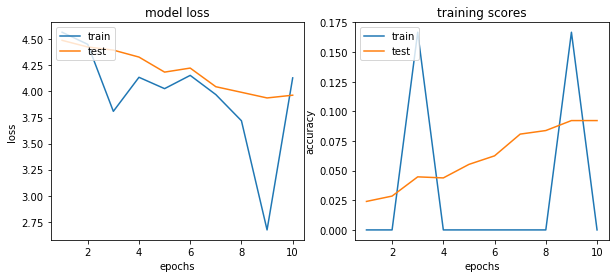

In [13]:
# plot
fig = plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(np.arange(1, epochs + 1), A[:, -1])  # train loss (on epoch end)
plt.plot(np.arange(1, epochs + 1), C)         #  test loss (on epoch end)
plt.title("model loss")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc="upper left")
# 2nd figure
plt.subplot(122)
plt.plot(np.arange(1, epochs + 1), B[:, -1])  # train accuracy (on epoch end)
plt.plot(np.arange(1, epochs + 1), D)         #  test accuracy (on epoch end)
# plt.plot(histories.losses_val)
plt.title("training scores")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc="upper left")
title = "./fig_UCF101_3DCNN.png"
plt.savefig(title, dpi=600)
# plt.close(fig)
plt.show()